# PoseNet Tests

In [6]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from datasets.apolloscape import Apolloscape
from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
import numpy as np
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import torch.optim as optim
from tqdm import tqdm
import os
import time
from datetime import datetime

from torchviz import make_dot

%matplotlib inline
plt.ion()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset

In [2]:
APOLLO_PATH = "./data/apolloscape"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])



# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    normalize
])

# record_name = "Record029"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road02_seg", transform=transform, record=record_name)

# record_name = "Record018" # Record018 - example with a turn
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg", transform=transform, record=record_name)

# record_name = "Record008"
# apollo_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
#                              transform=transform, record=record_name, normalize_poses=True,
#                              pose_format='quat')


stereo = False
shuffle = True

train_record = 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True, stereo=stereo)
val_record = 'Record013'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True, stereo=stereo)


# train_record = None # 'Record001'
# train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg",
#                              transform=transform, record=train_record, normalize_poses=True,
#                              pose_format='quat', train=True, cache_transform=True)
# val_record = None # 'Record011'
# val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="road03_seg",
#                              transform=transform, record=val_record, normalize_poses=True,
#                              pose_format='quat', train=False, cache_transform=True)




print(train_dataset)
print(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=shuffle) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=shuffle) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: Record001
    Train: True
    Normalize Poses: True
    Stereo: False
    Length: 242 of 2242
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record013
    Train: False
    Normalize Poses: True
    Stereo: False
    Length: 240 of 756
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



### Get Records Counts

In [3]:
# Show records with numbers of data points
recs_num = val_dataset.get_records_counts()
recs_num = sorted(recs_num.items(), key=lambda kv: kv[0], reverse=True)
print("Records Val:")
print("\n".join(["\t{} - {}".format(r[0], r[1]) for r in recs_num ]))


Records Val:
	Record014 - 100
	Record013 - 240
	Record012 - 242
	Record011 - 174
	Record010 - 0
	Record009 - 0
	Record008 - 0
	Record007 - 0
	Record006 - 0
	Record004 - 0
	Record003 - 0
	Record002 - 0
	Record001 - 0


### Checking Datasets

len(batch) = 2
len(batch[0]) = 8
len(batch[0][0]) = 3
batch_poses[0] =  tensor([ 0.2624,  1.4620, -0.4157,  0.5052, -0.6708,  0.4086, -0.3576])
unnormalized pose =  [ 4.82335999e+02 -1.88221399e+03  4.00550000e+01  5.05150020e-01
 -6.70801044e-01  4.08612400e-01 -3.57610494e-01]


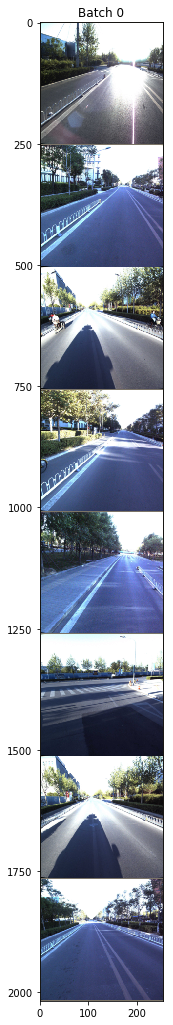

In [4]:
def collate_batch_images(batch_samples):
    just_images = [torch.cat(x, dim=2) for x in zip(*batch_samples[0])]
    return just_images


train_dataloader_iter = iter(train_dataloader)
train_batch = next(train_dataloader_iter)

print('len(batch) = {}'.format(len(train_batch)))
print('len(batch[0]) = {}'.format(len(train_batch[0])))
print('len(batch[0][0]) = {}'.format(len(train_batch[0][0])))

if stereo:
    pose = train_batch[1][0][0]
else:
    pose = train_batch[1][0]
    
    
print('batch_poses[0] = ', pose)

npose = np.zeros(7)
npose[:3] = pose.numpy()[:3] * train_dataset.poses_std[:3] + train_dataset.poses_mean[:3]
npose[3:] = pose.numpy()[3:]
pose = npose
print('unnormalized pose = ', pose)

if stereo:
    images_col = collate_batch_images(train_batch)
else:
    images_col = train_batch[0]

img_out = vutils.make_grid(images_col, nrow=1)
imshow(img_out, title="Batch 0", img_normalized=True)

### Draw Train and Val datasets

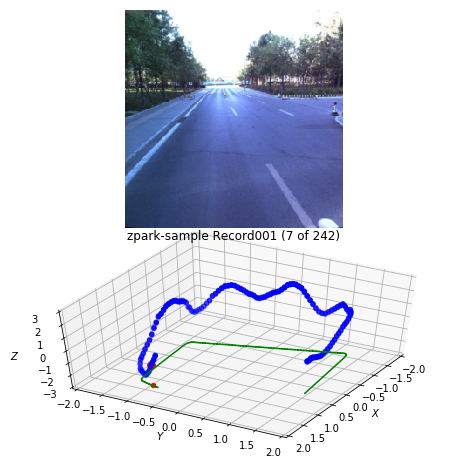

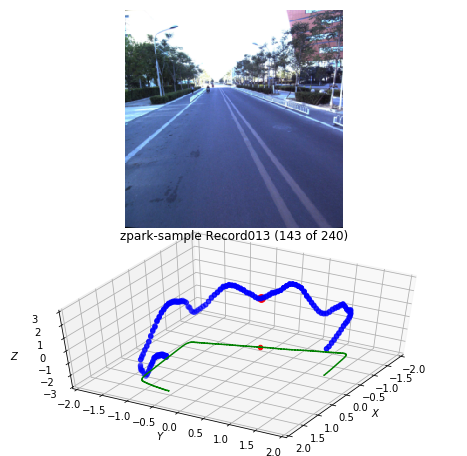

In [5]:
# Draw datasets
draw_record(train_dataset)
plt.show()

record_id = 'Record013'
draw_record(val_dataset, record=record_id, img_normalized=True)
plt.show()



### PoseNet model

In [11]:
class PoseNet(torch.nn.Module):
    
    def __init__(self, feature_extractor, num_features=128):
        super(PoseNet, self).__init__()
        self.feature_extractor = feature_extractor
        self.feature_extractor.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        fc_in_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = torch.nn.Linear(fc_in_features, num_features)
        
        # Translation
        self.fc_xyz = torch.nn.Linear(num_features, 3)
        
        # Rotation in quaternions
        self.fc_quat = torch.nn.Linear(num_features, 4)
        
    def extract_features(self, x):
        x_features = self.feature_extractor(x)
        x_features = F.relu(x_features)
        x_features = F.dropout(x_features, p=0.5, training=self.training)
        return x_features
        
    def forward(self, x):
        
        if type(x) is list:
            x_features = [self.extract_features(xi) for xi in x]
            x_translations = [self.fc_xyz(xi) for xi in x_features]
            x_rotations = [self.fc_quat(xi) for xi in x_features]
            x_poses = [torch.cat((xt, xr), dim=1) for xt, xr in zip(x_translations, x_rotations)]  
        elif torch.is_tensor(x):
            x_features = self.extract_features(x)
            x_translations = self.fc_xyz(x_features) 
            x_rotations = self.fc_quat(x_features)
            x_poses = torch.cat((x_translations, x_rotations), dim=1)
        
        return x_poses


# Create model
feature_extractor = models.resnet18(pretrained=True)
model = PoseNet(feature_extractor)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# print(model)


### PoseNetCriterion and sanity checks

In [12]:
# test_imgs1 = torch.rand(10, 3, 250, 250)
# test_imgs2 = torch.rand(10, 3, 250, 250)
if stereo:
    batch_images = [torch.rand(1, 3, 250, 250) for _ in range(2)]
    batch_poses = [torch.rand(1, 7) for _ in range(2)]
else:
    batch_images = torch.rand(1, 3, 250, 250)
    batch_poses = torch.rand(1, 7)
    
class PoseNetCriterion(nn.Module):
    def __init__(self, stereo=True, beta = 200.0):
        super(PoseNetCriterion, self).__init__()
        self.loss_fn = nn.L1Loss()
        self.stereo = stereo
        self.beta = beta
    
    def forward(self, x, y):
        """
        Args:
            x: list(N x 7, N x 7) or N x 7 - prediction (xyz, quat)
            y: list(N x 7, N x 7) or N x 7 - target (xyz, quat)
        """
        loss = 0
        if self.stereo:
            for i in range(2):
                # Translation loss
                loss += self.loss_fn(x[i][:, :3], y[i][:, :3])
                # Rotation loss
                loss += self.beta * self.loss_fn(x[i][:, 3:], y[i][:, 3:])
                
            # Normalize per image so we can compare stereo vs no-stereo mode
            loss = loss / 2
        else:
            # Translation loss
            loss += self.loss_fn(x[:, :3], y[:, :3])

            # Rotation loss
            loss += self.beta * self.loss_fn(x[:, 3:], y[:, 3:])


        return loss
    

out = model(batch_images)
print('out = {}'.format(out))

criterion = PoseNetCriterion(stereo=stereo)
loss = criterion(out, batch_poses)
print('loss = {}'.format(loss))

optimizer.zero_grad()
loss.backward()
optimizer.step()




out = tensor([[-0.3843, -0.5872, -0.0281, -0.0086, -0.0056, -0.1559, -0.1017]],
       grad_fn=<CatBackward>)
loss = 126.75274658203125


### Device set up

In [13]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


### Train and Validate functions

In [19]:
class AverageMeter():
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, value, n=1):
        self.val = value
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count


# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch):
    
    # switch model to training
    model.train()
    
    log_freq = 10
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         if idx < len(train_loader) - 1: continue
        data_time = (time.time() - end)
        
        if type(batch_images) is list:
            batch_images = [x.to(device) for x in batch_images]
        else: 
            batch_images = batch_images.to(device)
            
        if type(batch_poses) is list:
            batch_poses = [x.to(device) for x in batch_poses]
        else:
            batch_poses = batch_poses.to(device)
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0) if stereo else batch_images.size(0))
        
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch + 1, max_epoch, idx + 1, len(train_loader),
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch+1, max_epoch, losses.avg))
    
    
def validate(val_loader, model, criterion, epoch):
    
    
    log_freq = 0 # len(val_loader)
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            
            # if stereo mode than we have lists
            if type(batch_images) is list:
                batch_images = [x.to(device) for x in batch_images]
            else: 
                batch_images = batch_images.to(device)

            if type(batch_poses) is list:
                batch_poses = [x.to(device) for x in batch_poses]
            else:
                batch_poses = batch_poses.to(device)

            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0) if stereo else batch_images.size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch + 1, batch_time=batch_time, data_time=data_time, losses=losses))
                
    print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch+1, losses.avg))
            
            
    
    

### Fresh model & optimizer

In [20]:
# Create model and optimizer
model = PoseNet(feature_extractor)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)


### Restore checkpoint

In [16]:
# Restore from checkpoint
# checkpoint_file = '_checkpoints/20180811_164448_road02_128_e010.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']
        

# if 'start_epoch' not in locals():
#     start_epoch = 0
# n_epochs = start_epoch + 1
# print('Epochs {} - {}'.format(start_epoch, n_epochs))


### Run Training

In [21]:

if 'start_epoch' not in locals():
    start_epoch = 0

n_epochs = start_epoch + 2
print('Training ...')
for e in range(start_epoch, n_epochs):
    
    train(train_dataloader, model, criterion, optimizer, e, n_epochs)
    
#     print('Validation ...')
    validate(val_dataloader, model, criterion, e)
    

Training ...
Epoch: [1/2]	Batch: [1/31]	Time: 0.066	Data Time: 0.052	Loss: 93.298	Avg Loss: 93.298	
Epoch: [1/2]	Batch: [11/31]	Time: 0.064	Data Time: 0.051	Loss: 58.114	Avg Loss: 61.128	
Epoch: [1/2]	Batch: [21/31]	Time: 0.067	Data Time: 0.052	Loss: 53.097	Avg Loss: 52.910	
Epoch: [1/2]	Batch: [31/31]	Time: 0.023	Data Time: 0.013	Loss: 52.081	Avg Loss: 48.666	
Epoch: [1/2]	Training Loss: 48.666
Epoch: [1]	Validation Loss: 27.922
Epoch: [2/2]	Batch: [1/31]	Time: 0.066	Data Time: 0.054	Loss: 27.545	Avg Loss: 27.545	
Epoch: [2/2]	Batch: [11/31]	Time: 0.065	Data Time: 0.053	Loss: 42.447	Avg Loss: 37.847	
Epoch: [2/2]	Batch: [21/31]	Time: 0.065	Data Time: 0.053	Loss: 40.408	Avg Loss: 37.951	
Epoch: [2/2]	Batch: [31/31]	Time: 0.023	Data Time: 0.014	Loss: 24.726	Avg Loss: 37.201	
Epoch: [2/2]	Training Loss: 37.201
Epoch: [2]	Validation Loss: 21.772


### Visualize PoseNet model

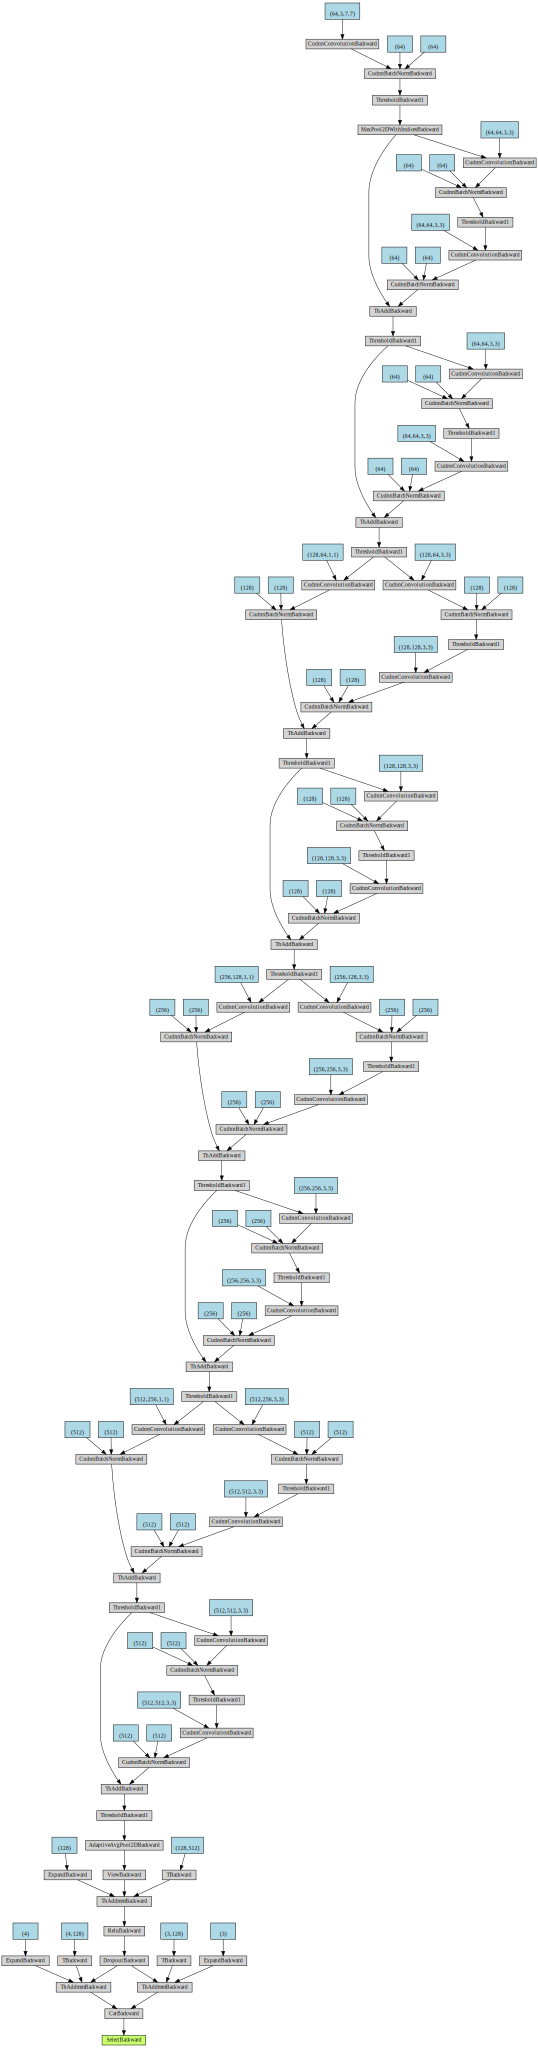

In [26]:
# for p in feature_extractor.parameters():
#     print(p.size())

# Test function for visiting backward graph
visited = set()
def visit_all(var, indent=''):
    if hasattr(var, 'data'):
        print("{}Data: {}".format(indent, var.data.size()))
    if hasattr(var, 'grad'):
        print("{}Grad Data: {}".format(indent, var.grad))
    if torch.is_tensor(var):
        print("{}Tensor {}".format(indent, var.size()))
    else:
        print("{}Type: {}".format(indent, type(var)))

    if hasattr(var, 'variable'):
        print("{}Variable: {}".format(indent, var.variable.size()))
        print("{}Data: {}".format(indent, var.variable))
        print("{}Data GRAD: {}".format(indent, var.variable.grad))
    if hasattr(var, 'saved_tensors'):
        print('{}Saved tensors: {}'.format(indent, var.saved_tensors))
    if hasattr(var, 'next_functions'):
        print('{}Next functions: {}'.format(indent, var.next_functions))
        for f in var.next_functions:
            if f[0] is not None:
                print("{}Function: {}".format(indent, f))
                visit_all(f[0], indent=indent+'  ')
    if hasattr(var, 'grad_fn'):
        print('{}Grad Fn: {}'.format(indent, var.grad_fn))
        visit_all(var.grad_fn, indent=indent+'  ')
    visited.add(var)
    
    
# visit_all(y)

# print(out.grad_fn.next_functions)

# out.__dir__()
# make_dot(out, params=dict(feature_extractor.named_parameters()))
out = model(batch_images.to(device))
make_dot(out[0])

### Simple test for model visualization

a = tensor([0.1067], requires_grad=True)
b = tensor([0.0514], requires_grad=True)
c = tensor([0.3545], requires_grad=True)
y = tensor([-0.2147], grad_fn=<ThMulBackward>)


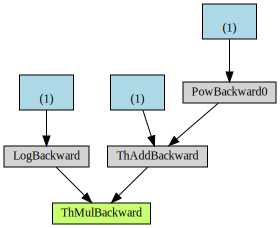

In [24]:
# Simple experiment to check backward graph state
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
c = torch.rand(1, requires_grad=True)
y = torch.log(a) * (b + torch.pow(c, 3))
print('a = {}'.format(a))
print('b = {}'.format(b))
print('c = {}'.format(c))
print('y = {}'.format(y))

# visit_all(y)
# print('--- BACKWARD ---')
# y.backward()
# visit_all(y)

make_dot(y)

### Save model checkpoint

In [27]:
# Save checkpoint
def save_checkpoint(model, optimizer, experiment_name='test', epoch=None):
    tstr = datetime.now().strftime('%Y%m%d_%H%M%S')
    fname = '{}_{}'.format(tstr, experiment_name)
    if epoch is not None:
        fname += '_e{:03d}'.format(epoch)
    fname += '.pth.tar'
    
    checkpoints_dir = '_checkpoints'
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    fname_path = os.path.join(checkpoints_dir, fname)
#     print('fname_path = {}'.format(fname_path))
    
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict()
    }
    
    torch.save(checkpoint_dict, fname_path)
    
    print('Model saved to {}'.format(fname_path))
    

save_checkpoint(model, optimizer, 'zpark_18', n_epochs)
    

Model saved to _checkpoints/20180824_082545_zpark_18_e002.pth.tar
